# RetailVision – U.S. Retail Sales Forecasting

In [1]:
# Import the libraries
!pip install prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

import warnings
warnings.filterwarnings("ignore")

## 1. Data Acquisition and Loading

In [2]:
# Load dataset  and create a dataframes
df = pd.read_csv("../data/us_advance_retail_sales.csv")

# Ensure datetime format
df['observation_date'] = pd.to_datetime(df['observation_date'], format='%d/%m/%Y')
df = df.set_index('observation_date')

# Align to month start
df.index = df.index.to_period('M').to_timestamp()
df.index.freq = 'MS'


In [3]:
print("First ten rows of the Retail  dataset:")
df.head(10)

First ten rows of the Retail  dataset:


,Retail Sales
observation_date,
1992-01-01,142419
1992-02-01,142584
1992-03-01,142120
1992-04-01,143659
1992-05-01,144239
1992-06-01,145273
1992-07-01,146743
1992-08-01,146070
1992-09-01,147932


In [4]:
print("Dimensions of the data frame:", df.shape)

Dimensions of the data frame: (403, 1)


## 2. EDA with Visualizations

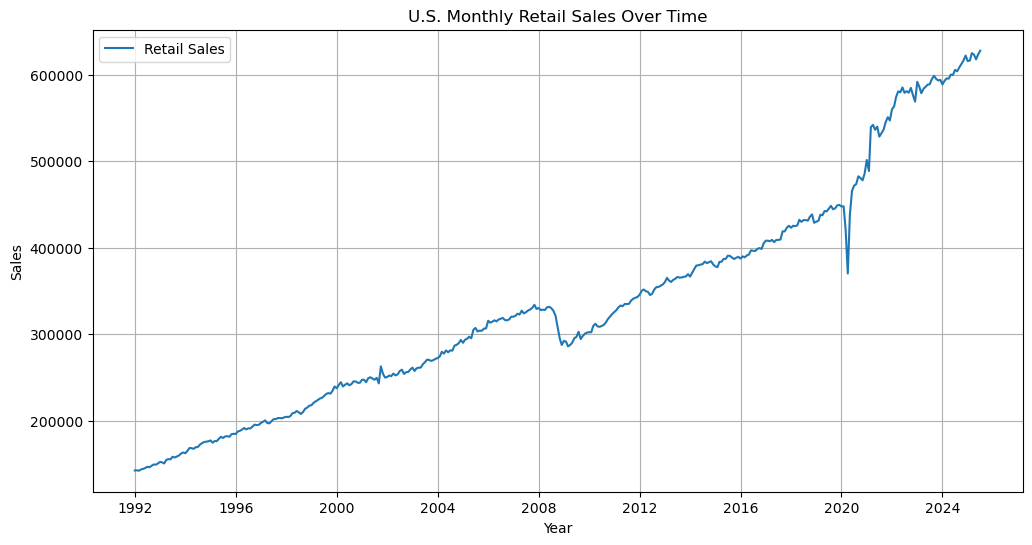

In [5]:
# Monthy Sales Over Time
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Retail Sales'], label='Retail Sales')
plt.title("U.S. Monthly Retail Sales Over Time")
plt.xlabel("Year")
plt.ylabel("Sales")
plt.grid(True)
plt.legend()
plt.show()

## Key insights from the graph:
- The graph shows a clear and steady long-term growth in US retail sales, indicating a consistently expanding economy and increasing consumer spending over the entire period.
-  The 2008-2009 financial crisis caused a noticeable dip in sales, while the 2020 COVID-19 pandemic led to an unprecedented surge in sales, showing how major macroeconomic events can significantly deviate from the regular trend and seasonal patterns.

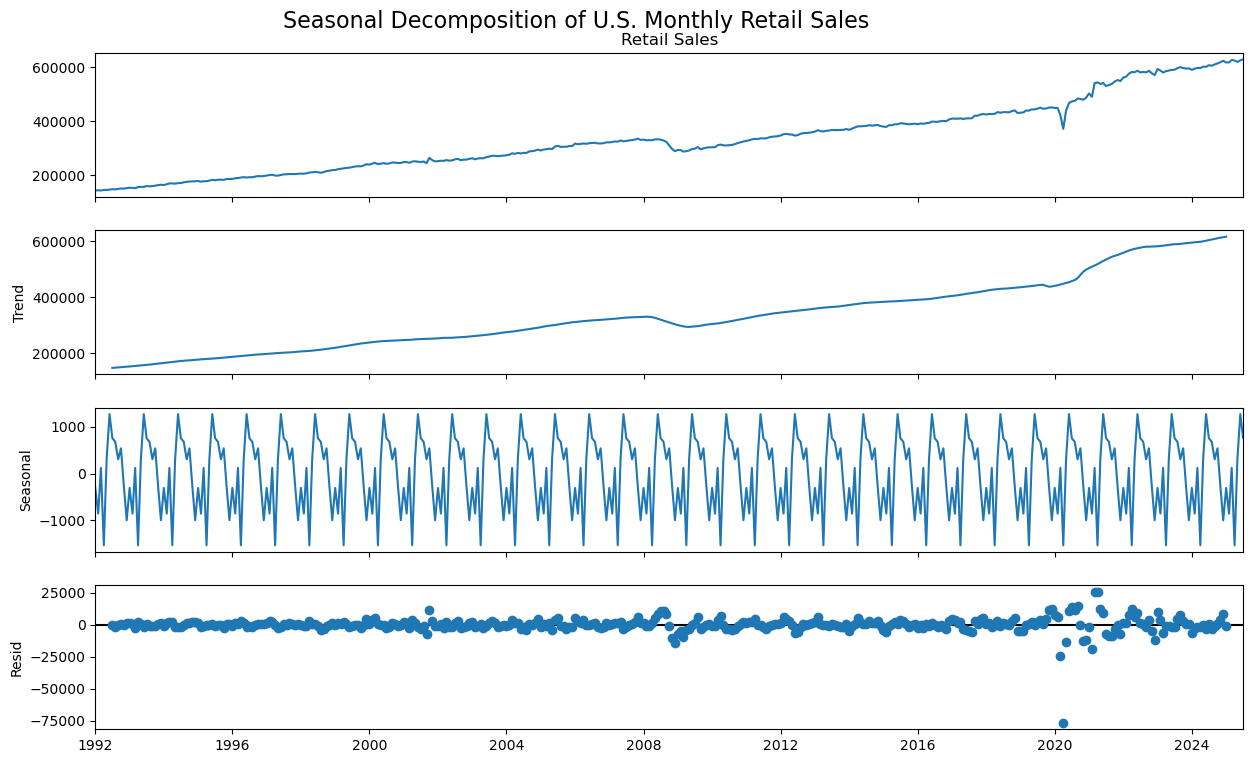

In [6]:
# Seasonal decomposition
decomposition = seasonal_decompose(df['Retail Sales'], model='additive', period=12)
fig = decomposition.plot()
fig.set_size_inches(14, 8)
fig.suptitle("Seasonal Decomposition of U.S. Monthly Retail Sales", fontsize=16)
plt.show()

## Key insights from the graph:
- The trend component shows a clear and consistent long-term growth in US retail sales, indicating an expanding economy.
-  The seasonal component reveals a very strong and predictable annual pattern with sales consistently peaking in December due to holidays and dipping in January and February.
-   The residuals component highlights the impact of external shocks. The 2008-2009 financial crisis caused sales to be lower than expected, while the 2020 COVID-19 pandemic led to an unprecedented and sudden surge.

## 3. Train-Test Split

In [34]:
train = df.iloc[:-24]   # all but last 24 months
test = df.iloc[-24:]    # last 24 months

## 4. Model 1: Linear Regression

In [35]:
df_lr = df.copy()

# Create lag features for Linear Regression
df_lr['lag1'] = df_lr['Retail Sales'].shift(1)
df_lr['lag12'] = df_lr['Retail Sales'].shift(12)

# Drop rows with NaN (first few months won't have lag12)
df_lr = df_lr.dropna()

# Train-test split (align with rest: last 24 months = test)
train_lr = df_lr.iloc[:-24]
test_lr = df_lr.iloc[-24:]

X_train = train_lr[['lag1','lag12']]
y_train = train_lr['Retail Sales']
X_test = test_lr[['lag1','lag12']]
y_test = test_lr['Retail Sales']

# Train model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test)

print("\nLinear Regression Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_lr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))


Linear Regression Performance:
MAE: 3443.757055257127
RMSE: 4101.816252038519


## 5. Model 2: SARIMA

### SARIMA model is used to forecast "Retail Sales" data. SARIMA stands for Seasonal Autoregressive Integrated Moving Average, and it's a powerful statistical model specifically designed for time series data with a seasonal component.

In [36]:
sarima_model = SARIMAX(train['Retail Sales'],
                       order=(1,1,1),
                       seasonal_order=(1,1,1,12))

sarima_fit = sarima_model.fit(disp=False)

start_index = len(train)
end_index = len(df) - 1
y_pred_sarima = sarima_fit.predict(start=start_index, end=end_index)

# Evaluation
print("\nSARIMA Performance:")
print("MAE:", mean_absolute_error(test['Retail Sales'], y_pred_sarima))
print("RMSE:", np.sqrt(mean_squared_error(test['Retail Sales'], y_pred_sarima)))



SARIMA Performance:
MAE: 4309.834148625062
RMSE: 5225.764457897


## 6. Model 3: Prophet Model

### Prophet is a forecasting model developed by Facebook that is well-suited for time series with strong seasonality and holiday effects. It is used here to capture long-term trends and recurring seasonal patterns in U.S. retail sales, complementing linear and SARIMA approaches.

In [37]:
# Prepare data for Prophet
prophet_df = df.reset_index()[['observation_date', 'Retail Sales']]
prophet_df.columns = ['ds', 'y']  # Prophet requires these column names

# Train-test split (last 24 months as test)
train_p = prophet_df.iloc[:-24]
test_p = prophet_df.iloc[-24:]

# Initialize and fit model
model = Prophet(yearly_seasonality=True, 
                weekly_seasonality=False, 
                daily_seasonality=False)
model.fit(train_p)

# Forecast for full dataset + future 24 months
future = model.make_future_dataframe(periods=24, freq='MS')
forecast = model.predict(future)

# Predictions for test period
y_pred_prophet = forecast.iloc[-24:]['yhat'].values
y_true_prophet = test_p['y'].values

# Evaluate
print("\nProphet Performance:")
print("MAE:", mean_absolute_error(y_true_prophet, y_pred_prophet))
print("RMSE:", np.sqrt(mean_squared_error(y_true_prophet, y_pred_prophet)))

11:12:10 - cmdstanpy - INFO - Chain [1] start processing
11:12:10 - cmdstanpy - INFO - Chain [1] done processing



Prophet Performance:
MAE: 8333.845429175732
RMSE: 9647.697506401357


## 7. Visualization of Predictions

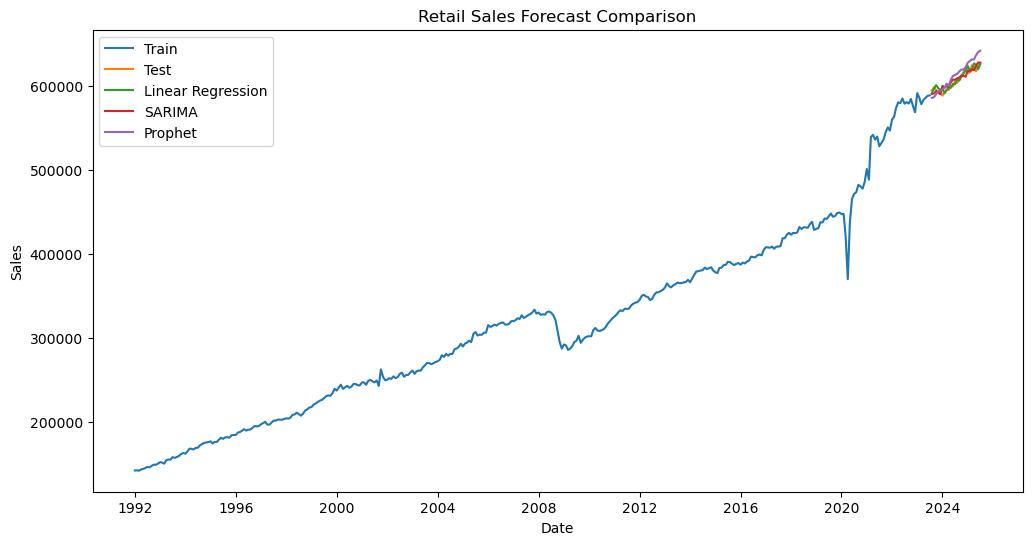

In [41]:
plt.figure(figsize=(12,6))
plt.plot(train.index, train['Retail Sales'], label='Train')
plt.plot(test.index, test['Retail Sales'], label='Test')
plt.plot(test.index, y_pred_lr, label='Linear Regression')
plt.plot(test.index, y_pred_sarima, label='SARIMA')
plt.plot(test.index, y_pred_prophet, label='Prophet')
plt.title("Retail Sales Forecast Comparison")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

### - With the lowest MAE (3,443) and RMSE (4,101), the Linear Regression model is the most accurate. This indicates its predictions were, on average, closest to the actual values. The model likely performed well by using lag features to capture the strong linear trend and some of the seasonality.
### - The SARIMA model, despite being designed for time series with seasonality, performed worse than the simple Linear Regression model, with higher MAE(4,309) and RMSE(5,225) values.
### - The Prophet model had the highest MAE (8,333) and RMSE (9,647), making it the least accurate of the three. Visually, its forecast line on the graph appears to have a different slope and does not align as well with the test data as the other models, particularly the Linear Regression model. 

## 8. Model Comparisions

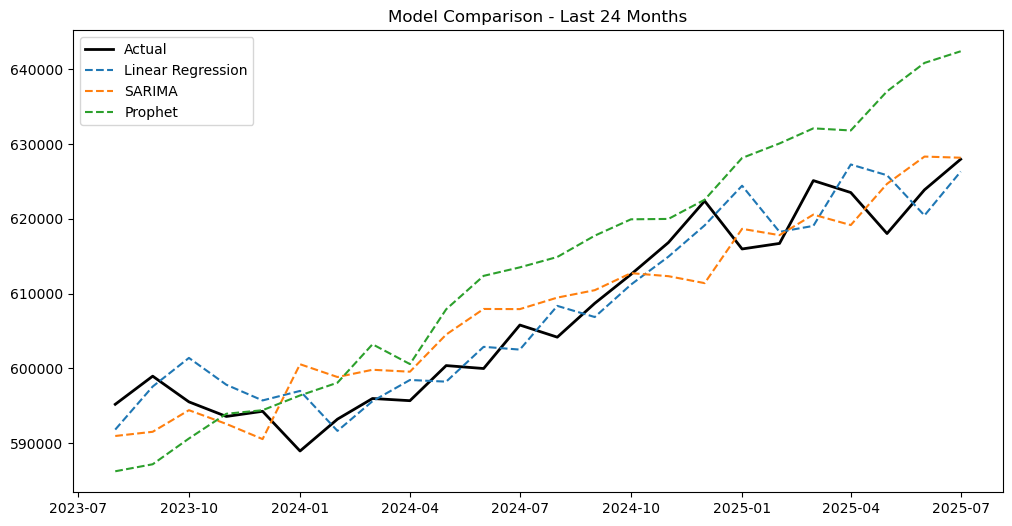

In [46]:
# Compare Model Predictions for Last 24 Months
plt.figure(figsize=(12,6))
plt.plot(test.index[-24:], test['Retail Sales'].tail(24), label="Actual", color="black", linewidth=2)
plt.plot(test.index[-24:], y_pred_lr[-24:], label="Linear Regression", linestyle="--")
plt.plot(test.index[-24:], y_pred_sarima[-24:], label="SARIMA", linestyle="--")
plt.plot(test.index[-24:], y_pred_prophet[-24:], label="Prophet", linestyle="--")
plt.legend()
plt.title("Model Comparison - Last 24 Months")
plt.show()


## 9. Future Predictions for next 12 months (SARIMA)

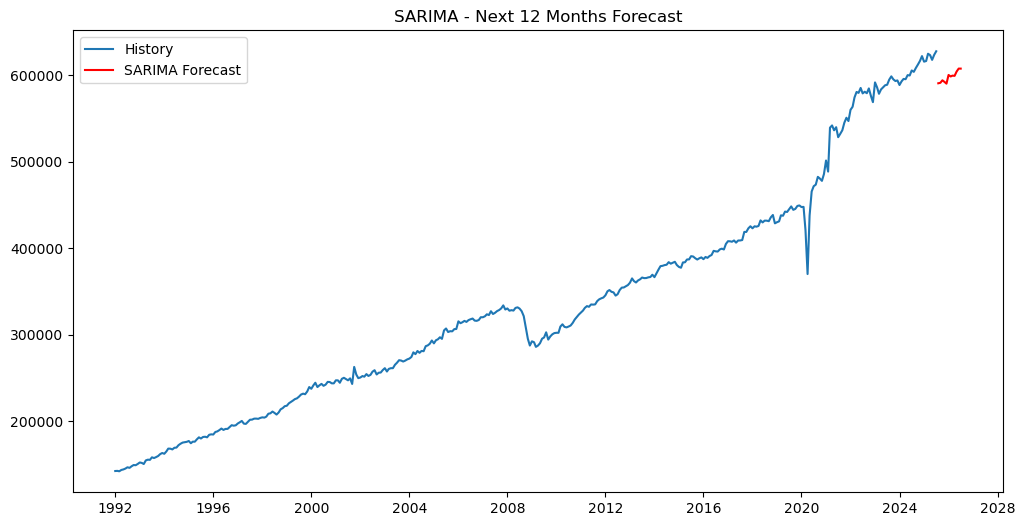

In [53]:
# Future prediction with SARIMA for next 12 months
future_sarima = sarima_fit.forecast(steps=12)

plt.figure(figsize=(12,6))
plt.plot(df.index, df['Retail Sales'], label="History")
plt.plot(pd.date_range(df.index[-1]+pd.offsets.MonthBegin(1), periods=12, freq='MS'),
         future_sarima, label="SARIMA Forecast", color="red")
plt.legend()
plt.title("SARIMA - Next 12 Months Forecast")
plt.show()
